# Workflow & Hyperparameter Optimization

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

🏠 Import the house price data set. We will keep only numerical features for the sake of simplicity

🎯 Your goal will be to fit the best KNN Regressor. In particular, how many "neighbors" (<font color=blue>K</font> in <font color=blue>K</font>NN) should you consider to get the best predictions for your house prices ?

In [2]:
# Load raw data
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv', index_col="Id")

# Only keep numerical columns and raws without NaN
data = data.select_dtypes(include=np.number).dropna()

data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,40,0,0,0,0,0,8,2007,175000
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,349,0,0,0,0,0,0,2,2010,210000
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,60,0,0,0,0,2500,5,2010,266500


In [3]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

## 1. Train/Test split

❓ **Question (Holdout)**❓

👇 Split the dataset to create your `X_train` `X_test` and `y_train` `y_test`. Use:
- `test_size=0.3`
- `random_state=0` to compare your results with your buddy

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 2. Scaling

⚖️ Scaling is always crucially important for the KNN algorithm..

❓ **Question (Scaling)** ❓ 

* Scale your train set and test set.
* Here, let's simply apply the `StandardScaler` and not waste time choosing one scaler per feature. Indeed, the goals of this exercise are to:
    * review KNN
    * understand GridSearchCV
    * understand RandomizedSearchCV

In [40]:
from sklearn.preprocessing import StandardScaler

st_scaler = StandardScaler().set_output(transform='pandas')
Xs_train = st_scaler.fit_transform(X_train)
Xs_test = st_scaler.transform(X_test)

## 3. Baseline KNN model

❓ **Question (A baseline for our KNN)** ❓

Cross-validate (*cv = 5*) a simple KNN regressor taking into account only _the closest neighbor_, and compute the average score over the 5 folds.

In [41]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate, cross_val_score

cross_val_score(estimator=KNeighborsRegressor(n_neighbors=1), X=Xs_train, y=y_train, cv=5).mean()

0.5601542887874071

## 4. GridSearch

### 4.1. A first GridSearch

❓ **Question (GridSearch v1)**❓

Let's use SKLearn `GridSearchCV` to find the best KNN hyperparameter `n_neighbors`.
- Start a coarse-grain approach, with `n_neighbors` = [1,5,10,20,50]
- 5-fold cross-validate each parameter
- Make sure to maximize your performance time using `n_jobs`

In [42]:
from sklearn.model_selection import GridSearchCV

# Instantiate model
KNN_model = KNeighborsRegressor()

# Hyperparameter Grid
param_grid = {'n_neighbors': [1, 5, 10, 20, 50]}

# Instantiate Grid Search
grid_search = GridSearchCV(estimator=KNN_model, param_grid=param_grid, n_jobs=-1)

# Fit data to Grid Search
grid_search.fit(Xs_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50]})

❓ **Question (best parameters)** ❓

According to the GridSearch, what is the optimal K value?

In [43]:
grid_search.best_params_

{'n_neighbors': 10}

❓ **Question (scoring)** ❓ What is the best score the optimal K value produced?

In [44]:
grid_search.best_score_

0.7596697382171873

### 4.2. A second GridSearch

❓ **Question (GridSearch V2)** ❓


Now, we have an idea about where the best $K$ lies, but some of the values we didn't try could result in a  better performance.

* Re-run a GridSearch trying some values for $K$ around to your previous best value
* What are the `best_score` and `best_k` for this refined GridSearch?

In [45]:
# Hyperparameter Grid
param_grid_2 = {'n_neighbors': [k for k in range(7, 18)]}

# Instantiate Grid Search
grid_search_2 = GridSearchCV(estimator=KNN_model, param_grid=param_grid_2, n_jobs=-1)

# Fit data to Grid Search
grid_search_2.fit(Xs_train, y_train)

best_k = grid_search_2.best_params_['n_neighbors']
best_score = grid_search_2.best_score_

print(best_k, best_score)

16 0.7666311417513013


***🧪 Test your code***

In [26]:
from nbresult import ChallengeResult
result = ChallengeResult('knn',
                         best_k=best_k,
                         best_score=best_score)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/bat/.pyenv/versions/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/bat/code/syanrys/05-ML/05-Model-Tuning/data-workflow/tests
plugins: dash-3.0.4, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_knn.py::TestKnn::test_best_k PASSED                                 [ 50%]
test_knn.py::TestKnn::test_best_score PASSED                             [100%]

============================== 2 passed in 0.10s ===============================


💯 You can commit your code:

git add tests/knn.pickle

git commit -m 'Completed knn step'

git push origin master



### 4.3. Visual check (manual GridSearch)

☝️ This problem is actually simple enough to perform a GridSearch manually.

❓ **Question(Manual GridSearch)** ❓

- Loop manually over all values of $K$ from $1$ to $50$ and store the average of the cross-validated scores of each model in a list.
- Plot the scores as a function of $K$ to visually find the best $K$ using the `Elbow Method`

In [27]:
Ks = [k for k in range(1,51)]
scores = [cross_val_score(estimator=KNeighborsRegressor(n_neighbors=k), X=Xs_train, y=y_train, cv=5).mean() for k in Ks]

<Axes: >

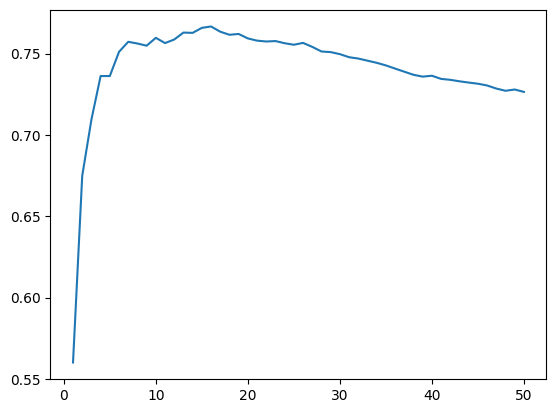

In [28]:
sns.lineplot(x=Ks, y=scores)

In [32]:
scores.index(max(scores))+1

16

❓Can you guess what makes GridSearchCV a better option than such manual loop ?


<details>
    <summary>Answer</summary>

- Sklearn's `n_jobs=-1` allows you to parallelize the search, utilizing all of your CPU cores
- What if you had multiple hyper-parameters to co-optimize?
</details>

## 5. GridSearch with multiple parameters

👩🏻‍🏫 KNNRegressor suppports various _distance metrics_ via the hyper-parameter `p` 

📚 [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

❓ **Question (tuning multiple parameters)** ❓


* Use GridSearchCV to search for the best $K$ and $p$ simultaneously.
    * Try all combinations for $K = [1, 5, 10, 20, 50]$ and $p = [1, 2, 3]$. 

In [56]:
param_grid_3 = {'n_neighbors': [1, 5, 10, 20, 50], 'p':[1, 2, 3]}
grid_search_3 = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid_3, n_jobs=-1)
grid_search_3.fit(Xs_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50], 'p': [1, 2, 3]})

❓ **Question (number of submodels)**❓

How many submodels did you train overall?

5 x 3 = 15

<details>
    <summary>Hint</summary>

Much more than 15. Think twice :)
    <details>
    <summary>Answer</summary>

75 models due to CV=5
</details>

❓ **Question (best parameters and best score after tuning the model with multiple parameters)**❓

What are the *best parameters* and the *best score*?

In [57]:
print(
    grid_search_3.best_params_,
    grid_search_3.best_score_
)

{'n_neighbors': 10, 'p': 1} 0.7969255879201194


## 6. Random Search

Now let's see whether a RandomizedSearch can find a better combination with the same number of models being fitted.

❓ **Question (RandomizedSearchCV)** ❓

Use `RandomizedSearchCV` to
- Randomly sample $K$ from a uniform `scipy.stats.randint(1,50)` ([doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html)) distribution
- Sample $p$ from a list $[1,2,3]$
- Use the correct numbers of `n_iter` and `cv` to fit the exact same numbers of models as in your previous GridSearchCV.

In [65]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

grid = {'n_neighbors': stats.randint(1,50), 'p':[1, 2, 3]}
search = RandomizedSearchCV(estimator=KNeighborsRegressor(), param_distributions=grid, n_iter=100,n_jobs=-1)
search.fit(Xs_train, y_train)

RandomizedSearchCV(estimator=KNeighborsRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f7ff9cc7320>,
                                        'p': [1, 2, 3]})

## 7. Generalization

❓ **Question (finetuning your model one more time)**❓

- Refine your RandomsearchCV if you want
- Choose your best model

In [66]:
print(search.best_params_, search.best_score_)

{'n_neighbors': 6, 'p': 1} 0.7978787384801239


Now try to display your `cv_results` as a `DataFrame`, this will help you visualize what's going on inside the CV! 😉

In [67]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
70,0.002435,0.001072,0.005484,0.001453,6,1,"{'n_neighbors': 6, 'p': 1}",0.719267,0.822341,0.768149,0.870533,0.809104,0.797879,0.051121,1
96,0.002592,0.000166,0.006129,0.000463,7,1,"{'n_neighbors': 7, 'p': 1}",0.736660,0.817465,0.757978,0.867009,0.795878,0.794998,0.045749,2
52,0.002033,0.000186,0.005689,0.000623,7,1,"{'n_neighbors': 7, 'p': 1}",0.736660,0.817465,0.757978,0.867009,0.795878,0.794998,0.045749,2
98,0.002770,0.000803,0.006634,0.001263,8,1,"{'n_neighbors': 8, 'p': 1}",0.750651,0.825437,0.742715,0.866525,0.785850,0.794236,0.046527,4
2,0.003011,0.000558,0.006997,0.001298,12,1,"{'n_neighbors': 12, 'p': 1}",0.761157,0.813126,0.732005,0.856813,0.790195,0.790659,0.042876,5


❓ **Question (Evaluation of the "best" model)** ❓

* Time has come to discover our model's performance with "best params" on the **unseen** test set `X_test`.
    * Compute the r2 score for the test set and save it as `r2_test`.

In [69]:
KNN_model = KNeighborsRegressor(n_neighbors=search.best_params_['n_neighbors'], p=search.best_params_['p'])
KNN_model.fit(Xs_train, y_train)
r2_test = cross_val_score(estimator=KNN_model, X=Xs_test, y=y_test).mean()
r2_test

0.7468723453549888

❓ **Question (Taking a step back)** ❓

Would you consider the optimized model to generalize well?

<details><summary>Answer</summary>

Test score may decrease a bit with train set. Probably not more than 5%. This can be due to
- A non-representative train/test split
- A cross-val number too small leading to overfitting the model-tuning phase. The more you cross-validated, the more robust your findings will generalize - but you can't increase cv too much if your dataset is too small as you won't keep enough observations in each fold to be representative.
- Our dataset is very small and our hyperparameter optimization is thus extremely dependent (and overfitting) on our train/test split. Always make sure your dataset is much bigger than the total number of hyperparameter combinations you are trying out!
    
</details>

***🧪 Test your code***

In [70]:
from nbresult import ChallengeResult
result = ChallengeResult('r2',
                         r2_test=r2_test)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/bat/.pyenv/versions/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/bat/code/syanrys/05-ML/05-Model-Tuning/data-workflow/tests
plugins: dash-3.0.4, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_r2.py::TestR2::test_r2 PASSED                                       [100%]

============================== 1 passed in 0.12s ===============================


💯 You can commit your code:

git add tests/r2.pickle

git commit -m 'Completed r2 step'

git push origin master



🏁 Congratulations! Now, you know how to finetune a model using either a GridSearchCV or a RandomizedSearchCV 

💾 Don't forget to `git add/commit/push` your notebook...

🚀 ... and move on to the next challenge!